# init

In [5]:
!pip install -U spacy
!pip install -U spacy-transformers
!python -m spacy download en_core_web_trf
!pip install -U sentence-transformers

/Users/aakarshsurendra/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 2.8 MB/s eta 0:00:0000:0100:06
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [7]:
import random
import pandas as pd
import spacy
import numpy as np
import pickle
import re
import matplotlib.pyplot as plt
import requests
import time
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [8]:
!python -m spacy validate

/Users/aakarshsurendra/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
ading compatibility table...✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.7.4) =================
ℹ spaCy installation:
/Users/aakarshsurendra/anaconda3/lib/python3.11/site-packages/spacy

NAME              SPACY            VERSION                            
en_core_web_sm    >=3.7.2,<3.8.0   3.7.1   ✔
en_core_web_lg    >=3.7.2,<3.8.0   3.7.1   ✔
en_core_web_trf   >=3.7.2,<3.8.0   3.7.3   ✔



## Functions

In [1]:
# Function to extract id from link
def extract_id(link):
    match = re.search(r'\b(\d{6,11})\b', link)
    if match:
        return match.group(1)
    else:
        return None

In [2]:
# Function to preprocess text using SpaCy
def preprocess_text_spacy(text):
    # Tokenize text and remove stopwords, punctuation, and lemmatize tokens
    doc = nlp(text)
    processed_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return processed_tokens

In [3]:
def One_Liners(dataset):
    nlp = spacy.load("en_core_web_trf")
    extracted_text = []

    for content in dataset['content']:
        doc = nlp(content)
        lines = content.split('\n')
        found = False
        for line in lines:
            if ":" in line:
                first_line_after_colon = line.split(":", 1)[1].strip()
                text_till_period = first_line_after_colon.split(".")[0]
                extracted_text.append(text_till_period)
                found = True
                break

        if not found:
            # Take the first row if no colon is found
            extracted_text.append(content.split(".")[0])

    # Append the extracted text to the dataset with a new column named "First Line"
    dataset['first_line'] = extracted_text

In [14]:
pwd

'/Users/aakarshsurendra/Desktop/ROAD_NLP/02_clustering'

In [17]:
# Load the transformer model
nlp = spacy.load("en_core_web_trf")

#Picking the output from the 01_extraction
file_path = '../01_extraction/output/data_road.csv'

dataframe = pd.read_csv(file_path)

### CREATING IDs FOR EACH NEWS

In [43]:
# Apply the function to extract ids
dataframe['id'] = dataframe['link'].apply(extract_id)
order = ['id','link','content','news_date']
dataframe = dataframe[order]

In [44]:
dataframe = dataframe.sample(50)

In [45]:
dataframe

,id,link,content,news_date
6955,75545477,https://timesofindia.indiatimes.com/city/kochi...,"KOCHI: Six people, including a man and his dau...","Updated: May 5, 2020, 07:34 IST"
6917,58251738,https://timesofindia.indiatimes.com/city/thane...,By: Avani Ghangurd e THANE: Five school studen...,"Updated: Apr 19, 2017, 07:07 IST"
6891,58886074,https://timesofindia.indiatimes.com/city/gurga...,GURUGRAM: A 24-year-old man was killed after b...,"Updated: May 29, 2017, 03:24 IST"
6680,84215978,https://timesofindia.indiatimes.com/city/rajko...,Rajkot: A 58-year-old police sub-inspector (PS...,"Jul 8, 2021, 04:06 IST"
434,100640277,https://timesofindia.indiatimes.com/city/luckn...,LUCKNOW: Four of a family travelling on a scoo...,"May 31, 2023, 11:11 IST"
2864,89356822,https://timesofindia.indiatimes.com/city/ludhi...,Ludhiana: BJP candidate from Gill constituency...,"Feb 5, 2022, 04:11 IST"
7239,74141328,https://timesofindia.indiatimes.com/city/nashi...,Nashik: Two youths were killed and one was cri...,"Feb 15, 2020, 04:28 IST"
7315,76536297,https://timesofindia.indiatimes.com/city/vadod...,Vadodara/ Anand: Three members of a Vadodara-b...,"Jun 24, 2020, 04:05 IST"
7218,85699849,https://timesofindia.indiatimes.com/business/i...,CHENNAI/MUMBAI: The Madras high court verdict ...,"Updated: Aug 28, 2021, 11:03 IST"
7577,79318645,https://timesofindia.indiatimes.com/india/priy...,NEW DELHI: Congress leader Priyanka Gandhi Vad...,"Nov 20, 2020, 13:21 IST"


# STAGE I CLUSTERING

#### Run only once and store the output TF-IDF vector file as pickle -

In [46]:
#If we need to run TF-IDF for fresh news, set run to True
run = True

In [47]:
if run == True:

    # Complete data (list of article texts)
    article_texts = dataframe.content

    # Handling NaN values by replacing them with empty strings
    article_texts_cleaned = article_texts.fillna('')

    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess_text_spacy)

    # Fit and transform the data
    tfidf_matrix = tfidf_vectorizer.fit_transform(article_texts_cleaned)

    #### Exporting the pickle file

    # Specify the file path where you want to save the TF-IDF matrix
    file_path = "tfidf_matrix.pkl"

    # Save the TF-IDF matrix to a file
    with open(file_path, 'wb') as f:
        pickle.dump(tfidf_matrix, f)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [48]:
tfidf_matrix.shape

(50, 2261)

## Load Pickle

#### Importing the pickle file - Run this

In [49]:
# Specify the file path where the TF-IDF matrix is saved
file_path = "tfidf_matrix.pkl"

# Load the TF-IDF matrix from the file
with open(file_path, 'rb') as f:
    tfidf_matrix = pickle.load(f)

In [50]:
tfidf_matrix

<50x2261 sparse matrix of type '<class 'numpy.float64'>'
	with 5256 stored elements in Compressed Sparse Row format>

### Clustering - To remove the unrelated news

In [103]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Store a copy of the original indexes
original_indexes = dataframe.index

# Initialize K-means clustering
num_clusters = 2  # You can adjust this based on the number of desired clusters
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=18, random_state=42)

# Fit the clustering model
kmeans.fit(tfidf_matrix)

# Get the cluster labels
cluster_labels = kmeans.labels_


### PCA

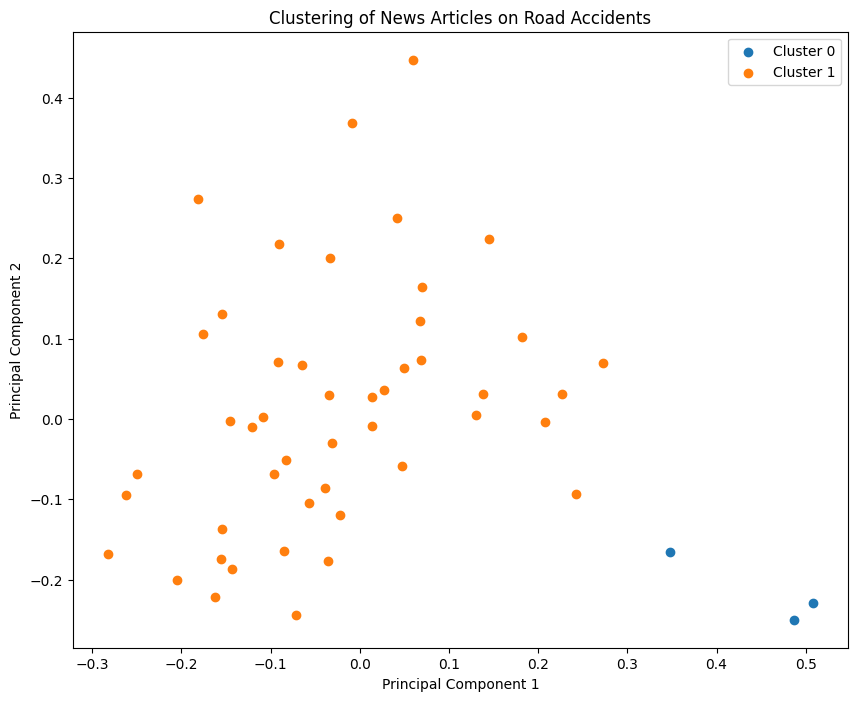

In [104]:
# Reduce dimensionality to 2 dimensions using PCA
pca = PCA(n_components=2)
tfidf_matrix_2d = pca.fit_transform(tfidf_matrix.toarray())

# Restore the original indexes
pca_dataframe = pd.DataFrame(tfidf_matrix_2d, columns=['PCA1', 'PCA2'], index=original_indexes)

# Visualize clusters
plt.figure(figsize=(10, 8))
for cluster_label in range(num_clusters):
    plt.scatter(pca_dataframe.loc[cluster_labels == cluster_label, 'PCA1'],
                pca_dataframe.loc[cluster_labels == cluster_label, 'PCA2'],
                label=f'Cluster {cluster_label}')
plt.title('Clustering of News Articles on Road Accidents')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

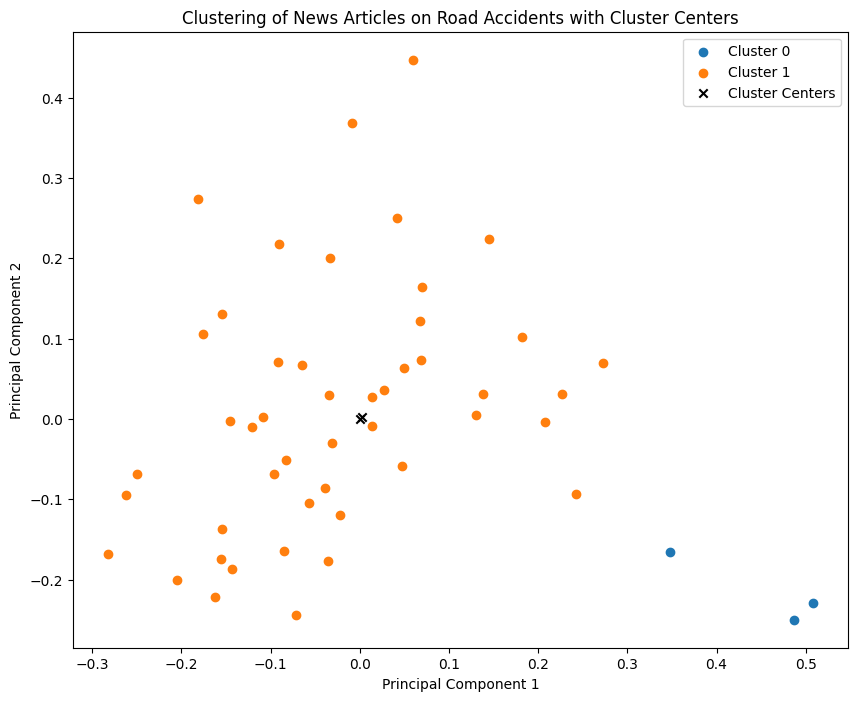

In [105]:
# Get cluster centers from K-means model
cluster_centers = kmeans.cluster_centers_

# Visualize clusters with cluster centers
plt.figure(figsize=(10, 8))
for cluster_label in range(num_clusters):
    plt.scatter(pca_dataframe.loc[cluster_labels == cluster_label, 'PCA1'],
                pca_dataframe.loc[cluster_labels == cluster_label, 'PCA2'],
                label=f'Cluster {cluster_label}')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
            marker='x', color='black', label='Cluster Centers')
plt.title('Clustering of News Articles on Road Accidents with Cluster Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

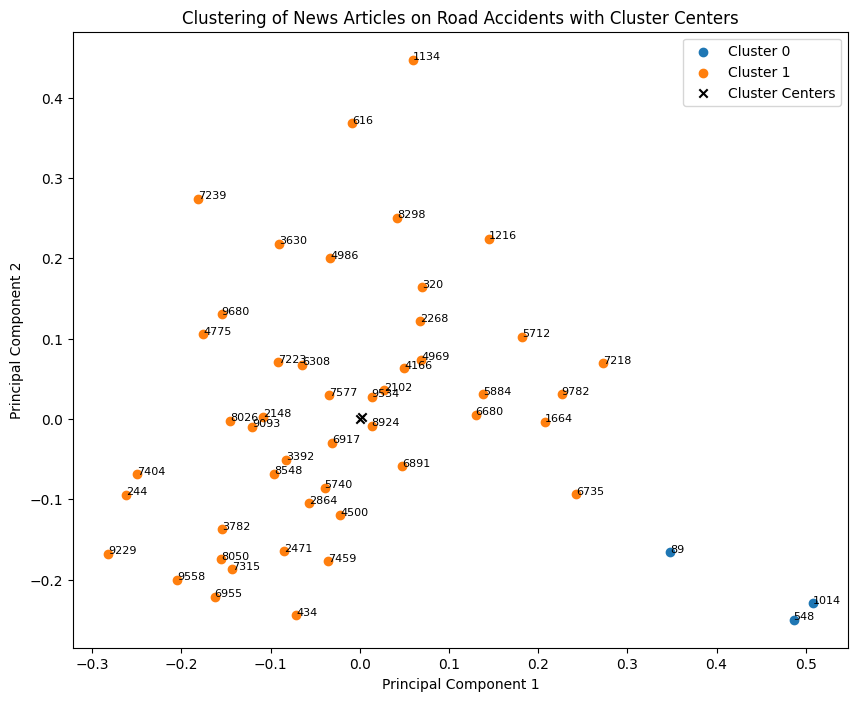

In [106]:
import numpy as np
import matplotlib.pyplot as plt

# Get cluster centers from K-means model
cluster_centers = kmeans.cluster_centers_

# Visualize clusters with cluster centers
plt.figure(figsize=(10, 8))
for cluster_label in range(num_clusters):
    cluster_points = pca_dataframe[cluster_labels == cluster_label]
    plt.scatter(cluster_points['PCA1'], cluster_points['PCA2'], label=f'Cluster {cluster_label}')
    # Add labels to each point
    for index, point in cluster_points.iterrows():
        plt.text(point['PCA1'], point['PCA2'], str(index), fontsize=8)

plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', color='black', label='Cluster Centers')
plt.title('Clustering of News Articles on Road Accidents with Cluster Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

### Cluster Extraction, Model Difference and Extracting the Unwanted News Dataset

In [109]:
stage1_cluster_0_points = pca_dataframe.index[cluster_labels == 0].tolist()
stage1_cluster_1_points = pca_dataframe.index[cluster_labels == 1].tolist()

In [110]:
random_10_elements = random.sample(stage1_cluster_0_points, k=1)
print(random_10_elements)

[1014]


#### Verifying the unwanted news

In [131]:
for index in random_10_elements:
    news_article = dataframe.loc[index, 'content']
    print(f"News Article {index}:\n{news_article}\n")

News Article 1014:
MUMBAI: In a detailed order granting bail to 40-year-old businessman Irfan Bilkiya , arrested for allegedly causing the October 5 sea link pile-up, in which five people were killed and 13 left injured, a sessions court has considered his lawyer's submissions that as his vehicle's mechanical condition rendered it not roadworthy and the brake system was not tested, he was well entitled for such relief. Denying the prosecution's allegations, the defence lawyer submitted the 52 challans, cited by the prosecution against the vehicle, did not belong to Bilkiya as the car was registered in his brother's name. "So, the prosecution has not shown any criminal antecedents to the discredit of the accused apart from what has been shown against his brother pertaining to traffic rules infringement," the court said. While the prosecution had initially opposed the bail plea, subsequently it conceded to it. Pointing to this, the court said, "...this order needs to be forwarded to DCP 

#### EXTRACT THE STAGE I FILTERNED NEWS

In [132]:
#Filtered Dataset from Stage I Clustering
filtered_dataset_1 = dataframe.drop(stage1_cluster_0_points)

# Reset the index of the new DataFrame
filtered_dataset_1.reset_index(drop=True, inplace=True)
filtered_dataset_1.drop(columns = ['Unnamed: 0'], inplace = True, errors='ignore')

In [133]:
filtered_dataset_1['id'] = filtered_dataset_1['link'].apply(extract_id)
order = ['id','link','content','news_date']
filtered_dataset_1 = filtered_dataset_1[order]

#### EXTRACT THE UNWANTED NEWS TO FEED TO STAGE II CLUSTERING

In [134]:
unwanted_news_stage1 = dataframe.drop(stage1_cluster_1_points)
unwanted_news_stage1.to_csv('unwanted_news.csv', index=False)

# STAGE II CLUSTERING

### SIMILARITY CHECK USING TRANSFORMER

In [135]:
unwanted_news = pd.read_csv('unwanted_news.csv')

In [136]:
# Load a pre-trained SentenceTransformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Example statement
example_statement = "Udaipur: Three members of a family from Banswara district were killed in a road accident on Monday morning when the car they were travelling in rammed into a stationary truck on eight-lane Delhi-Mumbai expressway near Mandsaur in Madhya Pradesh. Three others travelling in the car were seriously injured. The incident took place around 6am when the car with members of a family rammed into a stationary truck. Two women occupants and a man were killed, and three other family members were grievously injured, said the police. The family from Banswara‚Äôs Mohan Colony was traveling by car from Mandsaur via Ratlam towards Banswara. A truck was parked on the highway after its tyre burst. Due to fog and low visibility, the car rammed into the truck from behind. In the accident, Ruchi Upadhyay (55), Deepika Trivedi (42) died on the spot while Gopesh Upadhyay (57) died during treatment. Three others, including the driver who were seriously injured, were taken to Ratlam Medical College Hospital."

# Assuming your dataset is stored in a DataFrame called 'unwanted_news'
# Filter out any non-string values from the 'content' column
unwanted_news = unwanted_news[unwanted_news['content'].apply(lambda x: isinstance(x, str))]

# Compute embeddings for the example statement
example_statement_embedding = model.encode([example_statement])[0]

# Compute embeddings for each content value in the dataset
content_embeddings = model.encode(unwanted_news['content'].tolist())

# Calculate cosine similarity between the example statement embedding and each content embedding
similarities = cosine_similarity([example_statement_embedding], content_embeddings)[0]

# Add the similarity scores as a new column in the DataFrame
unwanted_news['similarity_score'] = similarities

In [137]:
# Assuming 'unwanted_news' is your DataFrame
similar_news = unwanted_news.loc[unwanted_news['similarity_score'] > 0.60]

similar_news.drop(columns = ['similarity_score','Unnamed: 0'], inplace = True, errors='ignore')

<ipython-input-137-cf40a9a670e4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_news.drop(columns = ['similarity_score','Unnamed: 0'], inplace = True, errors='ignore')


## EXTRACTING STAGE II FILTERED DATA

In [138]:
similar_news['id'] = similar_news['link'].apply(extract_id)
order = ['id','link','content','news_date']
filtered_dataset_2 = similar_news[order]

In [139]:
filtered_dataset = pd.concat([filtered_dataset_1, filtered_dataset_2], ignore_index=True)
filtered_dataset

,id,link,content,news_date
0,75545477,https://timesofindia.indiatimes.com/city/kochi...,"KOCHI: Six people, including a man and his dau...","Updated: May 5, 2020, 07:34 IST"
1,58251738,https://timesofindia.indiatimes.com/city/thane...,By: Avani Ghangurd e THANE: Five school studen...,"Updated: Apr 19, 2017, 07:07 IST"
2,58886074,https://timesofindia.indiatimes.com/city/gurga...,GURUGRAM: A 24-year-old man was killed after b...,"Updated: May 29, 2017, 03:24 IST"
3,84215978,https://timesofindia.indiatimes.com/city/rajko...,Rajkot: A 58-year-old police sub-inspector (PS...,"Jul 8, 2021, 04:06 IST"
4,100640277,https://timesofindia.indiatimes.com/city/luckn...,LUCKNOW: Four of a family travelling on a scoo...,"May 31, 2023, 11:11 IST"
5,89356822,https://timesofindia.indiatimes.com/city/ludhi...,Ludhiana: BJP candidate from Gill constituency...,"Feb 5, 2022, 04:11 IST"
6,74141328,https://timesofindia.indiatimes.com/city/nashi...,Nashik: Two youths were killed and one was cri...,"Feb 15, 2020, 04:28 IST"
7,76536297,https://timesofindia.indiatimes.com/city/vadod...,Vadodara/ Anand: Three members of a Vadodara-b...,"Jun 24, 2020, 04:05 IST"
8,85699849,https://timesofindia.indiatimes.com/business/i...,CHENNAI/MUMBAI: The Madras high court verdict ...,"Updated: Aug 28, 2021, 11:03 IST"
9,79318645,https://timesofindia.indiatimes.com/india/priy...,NEW DELHI: Congress leader Priyanka Gandhi Vad...,"Nov 20, 2020, 13:21 IST"


In [140]:
filtered_dataset.to_csv('output/filtered_dataset.csv', index = False)

# DATA CLEANING

In [23]:
df = pd.read_csv('output/filtered_dataset.csv')

In [142]:
# Extracting the first line from the filtered news
One_Liners(df)

In [143]:
df.to_csv('/output/filtered_dataset_oneliner.csv', index = False)